
# Assignment 1: Exploring Word Embeddings
**Course Name:** Natural Language Processing (CSC6052/5051/4100/DDA6307/MDS5110)





*Please enter your personal information (make sure you have copied this colab)*

**Name:**

**Student ID:**






In [1]:
# test
print(f'student id: 224040074')

student id: 224040074


## Assignment Requirements

This Colab file includes all contents for Assignment 1.

#### You are required to:

1. **Make a copy of the provided Google Colab file.**  
   First, you need to make a copy of the provided file into your own Google Drive. To accomplish this, open the Colab file link, navigate to `File` → `Save a copy in Drive`.

2. **Execute the notebook to generate results.**  
   You can click on "Connect to GPU" to apply for a free T4 GPU. Then, you can press the large play button to run a code cell.

3. **Complete the Necessary Parts.**  
   Some sections of the code are incomplete and require your input, especially pay attention to the parts marked with **<font color="red">[Task]</font>**. These sections are critical for scoring the assignment.

For more detailed instructions, refer to [Working with Google Colab](https://docs.google.com/document/d/1vMe8kC-oSyP3w7rIurDbG3NqfyQw7sZJ2C_S2ngtQnk/edit?usp=sharing).

## Submission Guidelines

Follow these steps to submit your assignment:

1. **Export the Notebook:** Navigate to `File` → `Download .ipynb` to download your notebook.

2. **Upload Your File:** Access the [Blackboard system](https://bb.cuhk.edu.cn/) and upload your `.ipynb` file.


## Overview

*Assignment 1* consists of two tasks:
- Task 1: Train Word Embeddings with Word2Vec (5 points)
- Task 2: Explore word embeddings (3 ponits)
- Task 3: Utilize word embeddings (2 points)

Your task is to **run all the code in this script** and complete the parts marked with <font color="red">[task]</font>.

## Prerequisite
If you're new to Python, Numpy, or PyTorch, consider these tutorials for a quick start:
- [Python-Numpy-Tutorial](https://cs231n.github.io/python-numpy-tutorial/)
- [Introduction to PyTorch](https://colab.research.google.com/drive/1obAmmGHsMizB38aiZJ_-L1bVMT5KOLMd?usp=sharing)

## Task 1: Train Word Embeddings with Word2Vec

**In this task, you will implement and train your own Word2Vec model.**

Before diving in, let's clarify what Word2Vec is.

Its core concept is straightforward: you can infer the meaning of a word from its neighbors - the words that frequently appear in the same context. Consider this illustration:
![Contexts](https://image.ibb.co/mnQ2uz/2018_09_17_21_07_08.png)

A basic approach is to use the context word counts as meaningful word vectors. Take this simple corpus for example:

```
The red fox jumped
The brown fox jumped
```

The count vectors would look like this:
```
        the fox jumped red brown
red   = (1   1    1     0    0)
brown = (1   1    1     0    0)
```

Notice how `red` and `brown` have similar vectors! We're close to solving the problem, but the goal is to obtain more compact embedding vectors.

This is where Word2Vec algorithms come into play. They construct embedding vectors based on the word's neighbors in the corpus.

For a more detailed introduction, check out this post: [king - man + woman = queen; but why?](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html).

Let's do some preparation work before moving to the interesting stuff.



In [1]:
!python --version

Python 3.12.3


### **1.1 Preparation**

Environment installation and data download

In [1]:
# i disabled some packages because no need of them

# !pip3 -qq install torch==1.1
# !pip -qq install nltk==3.8 #3.2.5

!pip -qq install nltk==3.8
!pip -qq install gensim
!pip -qq install bokeh==3.2.0

# !pip install nltk
# !pip install gensim
# !pip install bokeh

# -qq means: do not print message while executing command
!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
!unzip -o quora.zip

import nltk
nltk.download('punkt')
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
%matplotlib inline
np.random.seed(42)

import pandas as pd
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# please ignore ERROR of package version conflict

1. Tokenize and lower-case texts.

In [2]:
quora_data = pd.read_csv('train.csv')

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())
texts = texts[:50000] # Accelerated operation
print(len(texts))

tokenized_texts = [word_tokenize(text.lower()) for text in tqdm(texts)]

assert len(tokenized_texts) == len(texts)
assert isinstance(tokenized_texts[0], list)
assert isinstance(tokenized_texts[0][0], str)

50000


100%|██████████| 50000/50000 [00:02<00:00, 24295.42it/s]


In [3]:
tokenized_texts[0]

['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india',
 '?']

2. Collect the indices of the words:

In [4]:
from collections import Counter

MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break

    word2index[word] = len(word2index)

index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]

print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 7226
Tokens count: 623563
Unknown tokens appeared: 35607
Most freq words: ['?', 'the', 'what', 'is', 'how', 'i', 'a', 'to', 'in', 'do', 'of', 'are', 'and', 'can', 'for', ',', 'you', 'why', 'it', 'best']


In [14]:
# 0-5 represent words ['<unk>', '?', 'the', 'what', 'is']
index2word[:5]

['<unk>', '?', 'the', 'what', 'is']

3. collect the context words

First of all, we need to collect all the contexts from our corpus.

In [5]:
# i think this is the most important part of training a word embedding network
# skipgram and cbow differs mostly in training/label data structure.

def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1)
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))

    return contexts

contexts = build_contexts(tokenized_texts, window_size=2)
# save a copy of contexts for later visualization purpose
contexts_copy = contexts

In [6]:
# check contexts data:
for i in contexts[:10]:
    print(i)

('what', ['is', 'the'])
('is', ['what', 'the', 'step'])
('the', ['what', 'is', 'step', 'by'])
('step', ['is', 'the', 'by', 'step'])
('by', ['the', 'step', 'step', 'guide'])
('step', ['step', 'by', 'guide', 'to'])
('guide', ['by', 'step', 'to', 'invest'])
('to', ['step', 'guide', 'invest', 'in'])
('invest', ['guide', 'to', 'in', 'share'])
('in', ['to', 'invest', 'share', 'market'])


Check, what you got:

In [7]:
contexts[:5]

[('what', ['is', 'the']),
 ('is', ['what', 'the', 'step']),
 ('the', ['what', 'is', 'step', 'by']),
 ('step', ['is', 'the', 'by', 'step']),
 ('by', ['the', 'step', 'step', 'guide'])]

4. Convert to indices

Let's convert words to indices:

In [8]:
# dict.get(keyname, value): return value if keyname not found in dict
# here, unknown words are all assign to indice 0
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context])
            for central_word, context in contexts]

In [9]:
# check word-to-indices data structures
for context, indices  in zip(contexts_copy[:10], contexts[:10]):
    print(f'{context} - {indices}')
    

('what', ['is', 'the']) - (3, [4, 2])
('is', ['what', 'the', 'step']) - (4, [3, 2, 1310])
('the', ['what', 'is', 'step', 'by']) - (2, [3, 4, 1310, 65])
('step', ['is', 'the', 'by', 'step']) - (1310, [4, 2, 65, 1310])
('by', ['the', 'step', 'step', 'guide']) - (65, [2, 1310, 1310, 2105])
('step', ['step', 'by', 'guide', 'to']) - (1310, [1310, 65, 2105, 8])
('guide', ['by', 'step', 'to', 'invest']) - (2105, [65, 1310, 8, 629])
('to', ['step', 'guide', 'invest', 'in']) - (8, [1310, 2105, 629, 9])
('invest', ['guide', 'to', 'in', 'share']) - (629, [2105, 8, 9, 696])
('in', ['to', 'invest', 'share', 'market']) - (9, [8, 629, 696, 399])


### **1.2 Continuous Bag of Words (CBoW) Word2vec**

We have learn skip-gram model in tutorial. Now, we will explore another popular Word2Vec paradigm called Continuous Bag of Words (CBoW). *CBoW* offers faster processing and slightly better accuracy for common words compared to the *Skip-Gram*, which is more effective with rare words.

**CBoW Structure**

Below is the CBoW model architecture:

![](https://i.ibb.co/StXTMFH/CBOW.png)

In CBoW, the goal is to predict a target word from its surrounding context, represented by the sum of context vectors.

We will leverage our understanding from the *Skip-Gram* model to implement *CBoW*.

1. **Batches Generations**
**<font color="red">[Task]</font>** : Implement the batch generator. **DONE**

**Hint**: The generator should produce a input matrix `(batch_size, 2 * window_size)` containing context word indices and a target matrix `(batch_size)` with central word indices.

In [10]:
def make_cbow_batches_iter(contexts, window_size, batch_size):
    # why word != 0? word[0] = kohinoor
    central_words = np.array([word for word, context in contexts if len(context) == 2 * window_size and word != 0])
    contexts = np.array([context for word, context in contexts if len(context) == 2 * window_size and word != 0])


    batches_count = int(math.ceil(len(contexts) / batch_size))
    print(f'central_words: {central_words.shape}, contexts: {contexts.shape}\n')
    # batch_size=32，那么就需要 12380个batch以后才完整地过了一遍数据集
    print('Initializing batches generator with {} batches per epoch'.format(batches_count))

    indices = np.arange(len(contexts))
    np.random.shuffle(indices)

    for i in range(batches_count):
      # 最后一个batch可能不够batch_size个数据, 取到最后一个indices
      batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
      batch_indices = indices[batch_begin: batch_end]

      # ------------------
      # Write your implementation here.

      contexts_batch = torch.LongTensor(contexts[batch_indices])
      central_word_batch = torch.LongTensor(central_words[batch_indices])

      batch = {'tokens': contexts_batch, 'labels': central_word_batch}

      # yied: avoid producing all batch at once/help save ram usage, this is to improv effi
      yield batch
      # ------------------
'''
we use yield at the end of for loop because of the next() function in the cell below
'''

'\nwe use yield at the end of for loop because of the next() function in the cell below\n'

Check it:

In [13]:
window_size = 2
batch_size = 32

batch = next(make_cbow_batches_iter(contexts, window_size=window_size, batch_size=batch_size))

batch

# check how is the training batch of CBoW model looks like

central_words: (396154,), contexts: (396154, 4)

Initializing batches generator with 12380 batches per epoch


{'tokens': tensor([[  58,   94,   48, 1362],
         [1903,   23,   16,   55],
         [  22,   57,  140,    2],
         [  41, 2878,    0,   40],
         [  12,    2,   13,  658],
         [   3,  136,   17,   82],
         [  82,    0,    0,    9],
         [   9,    2,   16, 1300],
         [   7, 2822,   65,  285],
         [  13,  251,  341,  359],
         [  51,  137,  825,   16],
         [ 174,    8,    2,  279],
         [   1,   49,   96,   82],
         [1344,    7,  718,   15],
         [  32,   12,   52, 1255],
         [ 919,   37,    3,  439],
         [   3,  101,   90,    1],
         [1625,   16,  286, 1798],
         [  31,    2,    0, 2535],
         [  94,    2,    9,  678],
         [3557, 6082,    2,  222],
         [  23,  157,    2,  132],
         [   3,    4, 1567,    9],
         [5965, 2500,    4,   44],
         [  19,  129,  567, 1077],
         [  27,    2,   11,    7],
         [  24,   56, 1962,    9],
         [ 942,   34,   98, 1000],
         [

In [12]:
assert isinstance(batch, dict)
assert 'labels' in batch and 'tokens' in batch

assert isinstance(batch['tokens'], torch.LongTensor)
assert isinstance(batch['labels'], torch.LongTensor)

assert batch['tokens'].shape == (batch_size, 2 * window_size)
assert batch['labels'].shape == (batch_size,)

# ======
print('\nall good so far, proceed.')


all good so far, proceed.


### Here we attach the `make_skip_gram_batches_iter` from Tutorials for reference

In [15]:
import random

def make_skip_gram_batches_iter(contexts, window_size, num_skips, batch_size):

    '''
    params 含义
    - contexts: 原始数据，假设为 (central_word<str>, context_words<tuple>) 的列表
    - window_size: 上下文窗口半径（总窗口大小为 2 * window_size）
    - num_skips: 每个中心词sample的上下文词的数量（每个中心词生成 num_skips 个样本）,2, 每个中心词在2*window_size的范围内随机采样num_skips个上下文词，因此你可以在最后生成的batch中观察到，tokens总是重复num_skips遍
    - batch_size: 每个批次的总样本数, 32

    assert 检查
    - batch_size 必须是 num_skips 的倍数，保证每个中心词生成的样本能均匀分配到批次中。
    - num_skips 不能超过总上下文词数量（2 * window_size）。

    '''
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * window_size

    # len(context) == 2 : avoid context that is not full-size of 2*window_size
    # typically words of start/end

    # word != 0 : avoid using <unk> words as central word
    central_words = [word for word, context in contexts if len(context) == 2 * window_size and word != 0]
    contexts = [context for word, context in contexts if len(context) == 2 * window_size and word != 0]

    batch_size = int(batch_size / num_skips)
    batches_count = int(math.ceil(len(contexts) / batch_size))

    print('Initializing batches generator with {} batches per epoch'.format(batches_count))

    indices = np.arange(len(contexts))
    np.random.shuffle(indices)

    for i in range(batches_count):
        batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
        batch_indices = indices[batch_begin: batch_end]

        # major difference from CBoW starts here
        batch_data, batch_labels = [], []

        for data_ind in batch_indices:
            central_word, context = central_words[data_ind], contexts[data_ind]
            
            # sample num_skips amount of contexts words around central words
            words_to_use = random.sample(context, num_skips)
            batch_data.extend([central_word] * num_skips)
            batch_labels.extend(words_to_use)
        
        # major difference ends
        yield {
            'tokens': torch.LongTensor(batch_data),
            'labels': torch.LongTensor(batch_labels)
        }

In [16]:
batch_skip_gram = next(make_skip_gram_batches_iter(contexts, window_size=2, num_skips=2, batch_size=32))

batch_skip_gram

# check how is the training data of skip-gram model looks like

Initializing batches generator with 24760 batches per epoch


{'tokens': tensor([ 592,  592,    3,    3,    6,    6,   24,   24, 2061, 2061,    9,    9,
          773,  773,  528,  528,   21,   21,   66,   66,    8,    8,   70,   70,
           11,   11,    8,    8,    2,    2, 1847, 1847]),
 'labels': tensor([  83,    5,   34,  132,  763,   14,    1, 1621,   11,    0,    1, 2965,
           15, 4108,   46,   56, 1925,   13,  478,   21,   20,  574,    5,   92,
           30,    2,   30,   66,   35,    0,  169,  214])}

2. **Model**
**<font color="red">[Task]</font>**: Build the `CBoWModel`.

**Hint**: You need to implement the `forward` method based on the CBoW architecture. The context embedding is represented as the average of their context embeddings.

In [34]:
# implement CBoW:
class CBoWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        # ------------------
        # Write your implementation here.

        embedded = self.embeddings(inputs)  # shape: (batch_size, 2*window_size, embedding_dim)

        # averaging 4 contexts words (window_size = 2) vectors
        mean_embedded = torch.mean(embedded, dim=1)  # (batch_size, embedding_dim)

        outputs = self.out_layer(mean_embedded)  # (batch_size, vocab_size)

        return outputs
        # ------------------
# here cbow and skipgram shares the same structure of nn

Check it:

In [38]:
'''
line marked with 'cuda #' in case codes are tested in a cpu local machine, you can safely ignore and run
'''
# automatically adapt to different device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device(type='cpu')
# cuda #1
model = CBoWModel(vocab_size=len(word2index), embedding_dim=32)#.cuda()
model.to(device)

# cuda #2
# outputs = model(batch['tokens'].cuda())
outputs = model(batch['tokens'].to(device))

# outputs = model(batch['tokens'])

# cuda #3
# no need to check if outputs is cuda.FloatTensor dtype
# assert isinstance(outputs, torch.cuda.FloatTensor)
# assert isinstance(outputs, torch.FloatTensor)

assert outputs.shape == (batch_size, len(word2index))
print('so far all good, proceed')

so far all good, proceed


3. **Training**
**<font color="red">[Task]</font>** : Train the CBoW.

**Hint**: Consider referring to the training code of the previously mentioned *Skip-gram* model.

In [39]:
# Here are the hyperparameters you can adjust
embedding_dim = 32
learning_rate = 0.001
epoch_num = 10 # default 5, can attempt more epochs num
batch_size = 128

# len(word2index) = 7226
model = CBoWModel(len(word2index),embedding_dim)
# Getting model to GPU
# cuda #3 ===
model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_every_nsteps = 3000 # report loss every 3000 steps
total_loss = 0
start_time = time.time()
global_step = 0

for ep in range(epoch_num):
  for step, batch in enumerate(make_cbow_batches_iter(contexts, window_size=2, batch_size=batch_size)):
      global_step += 1

      # ------------------
      # Write your implementation here.

      # cuda #4 ====
      inputs = batch['tokens'].to(device)  # contexts
      labels = batch['labels'].to(device)  # central_words

      # forward
      outputs = model(inputs)  # shape: (batch_size, vocab_size)

      # cal loss
      loss = criterion(outputs, labels)

      # bp
      optimizer.zero_grad()  # zero out grad every new batch
      loss.backward()        # bp
      optimizer.step()       # update weights
      # ------------------

      total_loss += loss.item()

      if global_step != 0 and global_step % loss_every_nsteps == 0:
          print("Epoch = {}, Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(ep, step, total_loss / loss_every_nsteps,time.time() - start_time))

          # reset diameter for next epochs
          total_loss = 0
          start_time = time.time()


central_words: (396154,), contexts: (396154, 4)

Initializing batches generator with 3095 batches per epoch
Epoch = 0, Step = 2999, Avg Loss = 6.4702, Time = 16.62s
central_words: (396154,), contexts: (396154, 4)

Initializing batches generator with 3095 batches per epoch
Epoch = 1, Step = 2904, Avg Loss = 5.5461, Time = 32.94s
central_words: (396154,), contexts: (396154, 4)

Initializing batches generator with 3095 batches per epoch
Epoch = 2, Step = 2809, Avg Loss = 5.2384, Time = 35.12s
central_words: (396154,), contexts: (396154, 4)

Initializing batches generator with 3095 batches per epoch
Epoch = 3, Step = 2714, Avg Loss = 5.0436, Time = 33.21s
central_words: (396154,), contexts: (396154, 4)

Initializing batches generator with 3095 batches per epoch
Epoch = 4, Step = 2619, Avg Loss = 4.9075, Time = 19.65s
central_words: (396154,), contexts: (396154, 4)

Initializing batches generator with 3095 batches per epoch
Epoch = 5, Step = 2524, Avg Loss = 4.7910, Time = 29.10s
central_wo

**Obtaining word embeddings**

Word embeddings are contained within the embeddings layer of the model. We just need to move them from the GPU to the CPU and convert them to a numpy array.

In [48]:
embeddings = model.embeddings.weight.data.cpu().numpy()
# if you dont convert tensor from cuda to cpu, error:
# TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
print(f'embedding size: {embeddings.shape}')
for i in range(len(embeddings[:3])):
    print(f'{contexts_copy[i][0]}:\n {embeddings[i]}')

embedding size: (7226, 32)
what:
 [ 0.96052194  0.05893503 -1.3039774  -0.88900465  0.677495    0.19581018
  0.8522649   0.42557326  0.2250157  -0.7901772   0.07134378  1.7866141
  0.50178045 -0.42438436  0.8282317  -0.68094814 -1.931252    0.6259549
  0.4067984   1.0212533  -0.5563819   1.480883   -0.94625306  0.03295426
  0.86704636 -1.0502287   0.38664585 -1.1708677   0.11243499 -1.7395645
  1.154449   -0.61125165]
is:
 [ 1.4916081  -1.3526965   0.8027263  -0.72304356  0.3714146  -0.68197644
 -2.487755   -2.1356645   0.7412488   0.2170881   2.030554   -1.1919757
  1.7313095  -0.6281554  -1.902759    2.85017     0.253746    1.1202734
 -1.7669542  -0.73531795 -1.9330088   1.1174059  -1.718955   -0.13146304
 -1.762283    1.2027557  -2.6531742   2.3456078   0.5439756   0.7073023
  3.780317    1.3381276 ]
the:
 [-1.7554145   0.29734474  5.097264    2.0101798  -0.06181643 -1.794369
 -1.2909542   1.9649345  -0.3047359  -0.12137443 -1.235201    2.4657967
 -1.3481038   0.39234203 -0.21756071

**Testing Trained Word Embeddings**

Let's check how adequate are similarities that the model learnt.

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]

    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]

    return [index2word[index] for index in reversed(top10)]

print(f'most similar words to \'my\':')
most_similar(embeddings, index2word, word2index, 'my')

most similar words to 'my':


['my',
 'his',
 'your',
 'her',
 'reader',
 'their',
 'someones',
 'believing',
 'tweets',
 'pandora']

**Visualization of our embeddings**

In [55]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=1)
    return scale(tsne.fit_transform(word_vectors))


def visualize_embeddings(embeddings, index2word, word_count):
    word_vectors = embeddings[1: word_count + 1]
    words = index2word[1: word_count + 1]

    word_tsne = get_tsne_projection(word_vectors)
    draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='blue', token=words)


visualize_embeddings(embeddings, index2word, 100)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 4.839828
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.675255
[t-SNE] KL divergence after 1000 iterations: 0.546376


d:\Anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Loading BokehJS ...

## Task 2： Explore Word Embeddings with Word2Vec
In this task, we shall explore the embeddings produced by word2vec. Please revisit the lecture slides or tutorials for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the original [paper](https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf).

Then run the following cells to load the word2vec vectors into memory. **Note**: This might take several minutes.

In [56]:
def load_word2vec():
    """ Load GloVe Twitter Vectors
        Return:
            wv_from_bin: Pre-trained embeddings with 25 dimensions for 1.2M vocabulary.
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-twitter-25")
    vocab = list(wv_from_bin.key_to_index.keys())  # Updated for Gensim 4.x
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [1]:
# # -----------------------------------
# # Run Cell to Load Word Vectors
# # Note: This may take several minutes
# # -----------------------------------

wv_from_bin = load_word2vec()

# save to local
import pickle
# # dump
file_name = 'wv_from_bin.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(wv_from_bin, f)

# re-load
with open(file_name, 'rb') as f:
    wv_from_bin = pickle.load(f)


In [9]:
# we want to check the structure of 'wv_from_bin', but wv_from_bin.key_to_index is a huge dictionary, so we adapt "yield" to iter 10 random items from the dict (dict is not ordered)
def list_10items_from_dict(dic):
    for i in dic.items():
        yield i

items_from_dict = list_10items_from_dict(wv_from_bin.key_to_index)
for i in range(10):
    print(next(items_from_dict))

print(f'vector (embedding) size: {wv_from_bin.vector_size}')
print(f'exmaple of embedded vector: \n{wv_from_bin.vectors[:2]}')

('<user>', 0)
('.', 1)
(':', 2)
('rt', 3)
(',', 4)
('<repeat>', 5)
('<hashtag>', 6)
('<number>', 7)
('<url>', 8)
('!', 9)
vector (embedding) size: 25
exmaple of embedded vector: 
[[ 0.62415   0.62476  -0.082335  0.20101  -0.13741  -0.11431   0.77909
   2.6356   -0.46351   0.57465  -0.024888 -0.015466 -2.9696   -0.49876
   0.095034 -0.94879  -0.017336 -0.86349  -1.3348    0.046811  0.36999
  -0.57663  -0.48469   0.40078   0.75345 ]
 [ 0.69586  -1.1469   -0.41797  -0.022311 -0.023801  0.82358   1.2228
   1.741    -0.90979   1.3725    0.1153   -0.63906  -3.2252    0.61269
   0.33544  -0.57058  -0.50861  -0.16575  -0.98153  -0.8213    0.24333
  -0.14482  -0.67877   0.7061    0.40833 ]]



**Reducing dimensionality of Word2Vec Word Embeddings**

Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

- Put the 1.2 million word2vec vectors into a matrix M
- Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 25-dimensional to 2-dimensional.



In [10]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 1.2 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

**Implement reduce_to_k_dim**

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

**<font color="red">[Task]</font>**: Complete reduce_to_k_dim function

In [11]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurrence count matrix of dimensionality (num_corpus_words, num_corpus_words to a matrix of dimensionality (num_corpus_words, k) using TruncatedSVD.

    truncated svd check: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
        
        Params:
            M (numpy matrix of shape (num_corpus_words, num_corpus_words)): co-occurrence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (num_corpus_words, k)): matrix of k-dimensional word embeddings.
    """
    n_iters = 10  # Number of iterations for SVD
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=0)  # truncated svd
    M_reduced = svd.fit_transform(M)  # dimensionality reduction

    # ------------------
    print("Done.")
    return M_reduced

In [21]:
# -----------------------------------------------------------------
# Run Cell to Reduce 25-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
import numpy as np
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)
print(f'M_reduced: {M_reduced}')

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.
M_reduced: [[ 2.4653165  -0.01928564]
 [ 2.8954818   0.09360451]
 [ 3.0669835   1.3508444 ]
 ...
 [ 0.19509113  0.46137983]
 [ 1.1864849   0.37794757]
 [-2.094064   -0.9062391 ]]


C:\Users\xuguy\AppData\Local\Temp\ipykernel_24880\3415616940.py:20: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))
C:\Users\xuguy\AppData\Local\Temp\ipykernel_24880\3415616940.py:27: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))


**Here is a helper function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (plt).**

In [16]:
import matplotlib.pyplot as plt

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus, k)): matrix of k-dimensional word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    plt.figure(figsize=(10, 10))
    for word in words:
        if word in word2Ind:
            idx = word2Ind[word]
            x, y = M_reduced[idx, 0], M_reduced[idx, 1]
            plt.scatter(x, y, marker='o', color='blue')
            plt.text(x + 0.02, y + 0.02, word, fontsize=9)
        else:
            print(f"Word '{word}' not found in word2Ind dictionary.")

    plt.title("Word Embeddings Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

### 2.1: Word2Vec Plot Analysis
Run the cell below to plot the 2D word2vec embeddings for ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela'].

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

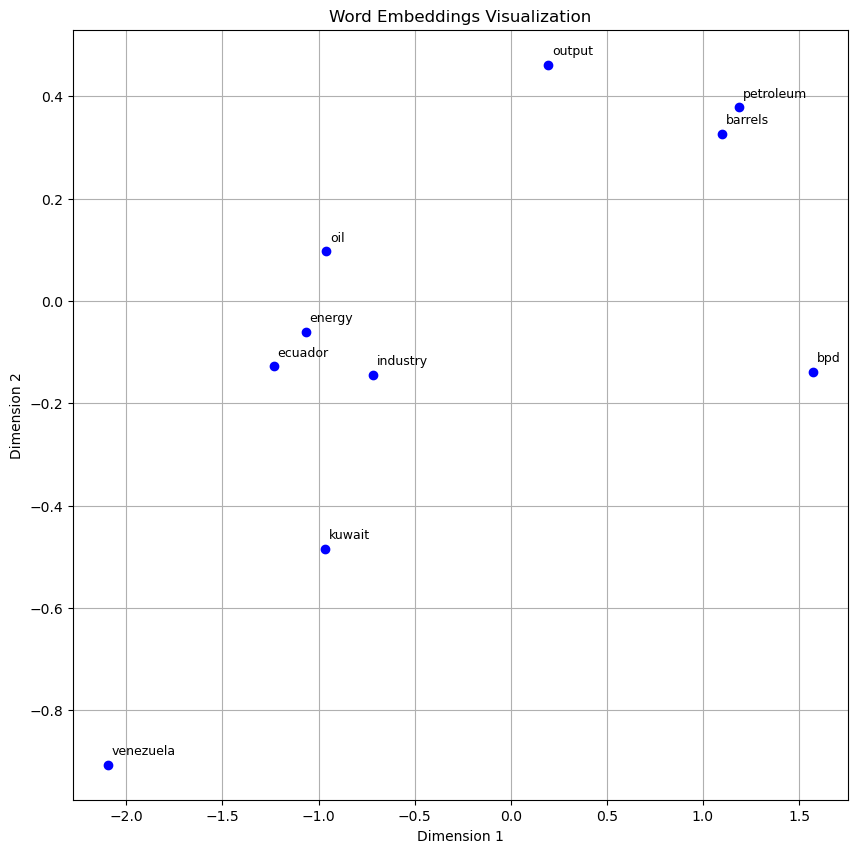

'\ndue to the randomness of truncated SVD, the plot will be different for each run of this cell\n'

In [22]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

'''
due to the randomness of truncated SVD, the plot will be different for each run of this cell
'''

**<font color="red">[Task]</font>**:Write your answer here.

1. What clusters together in 2-dimensional embedding space?
   - oil/patro production countries, like **ecuador**, **kuwait** etc, cluster together with **oil** and **patro**
2. What doesn't cluster together that you might think should have? 
   - **venezuela** should cluster with those mentioned above because **venuzuela** is a oil production country so it is closely related to **oil** or **patro**, but it doesn't
3. How is the plot different from the one generated earlier from the co-occurrence matrix?
   - ? wdym co-occurrence matrix? we have never dealed with co-occurence matrix before in this hw. do you mean the plot of matrix generated by cbow(Word2Vec)?
   - difference of the matrix generated before and this one: they use different dimension-reduction algo, the one before use t-SNE from sklearn, this one use truncated-svd. can't see any significant difference from these 2.

### 2.2 Polysemous Words
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from both meanings. For example, "leaves" has both "turns" and "ground" in the top 10, and "scoop" has both "buckets" and "pops". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

Note: You should use the wv_from_bin.most_similar(word) function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the GenSim [documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar).

In [23]:
# ------------------
# Write your polysemous word exploration code here.
'''
思路：1. 筛选出长度大于6的词，这些长词大部分都是名词、形容词、副词，这些词才好判断词义 2. 重点考察名词、形容词
'''
# 获取vocab
vocabList = list(wv_from_bin.key_to_index.keys())
len(vocabList) # 1193514

def find_alpha(vocab, word_length=4):
    wordsAlpha = []
    # 找出前1000词中，由纯字母构成的词：str.isalpha()
    for word in vocab[:1000]:
        if word.isalpha() and len(word) >=word_length:
            wordsAlpha.append(word)
    return wordsAlpha
# 筛选出长度大于或等于5的词，因为大多数非形容词长度都比较小
alpha = find_alpha(vocabList[:1000], word_length = 6)

# 打印出前10个看看
print(alpha[:10])


['follow', 'people', 'really', 'please', 'twitter', 'hahaha', 'someone', 'always', 'because', 'thanks']


In [24]:
# 给定候选词，找出每个候选词的10个most_similar words，然后人工判断polysemous words
def polysemous(candidate_words):

    for word in candidate_words:
        try:
            top_10_similar = wv_from_bin.most_similar(word, topn=10)
            top_10_words = [w for w, _ in top_10_similar]

            # Check if the top-10 similar words contain evidence of multiple meanings
            # (e.g., related words from both senses)
            # This is a heuristic and may need adjustment based on the word.
            if len(set(top_10_words)) >= 2:  # At least two distinct meanings
                print(f"Testing word: {word}")
                print(f"Top 10 similar words: \n{top_10_words}\n")

        except KeyError:
            print('words not found in vocab')
            continue

# 随意选择了一些候选词：
candidate_words = ['hard', 'summit' ,'tomorrow', 'little', 'believe']
polysemous(candidate_words)

# ------------------



Testing word: hard
Top 10 similar words: 
['even', 'bad', 'fall', 'shit', 'its', 'harder', 'it', 'nothing', 'way', 'fast']

Testing word: summit
Top 10 similar words: 
['conference', 'alliance', 'convention', 'international', 'district', 'academy', 'development', 'chamber', 'arts', 'center']

Testing word: tomorrow
Top 10 similar words: 
['saturday', 'monday', 'friday', 'tonight', 'thursday', 'wednesday', 'today', 'soon', 'tuesday', 'coming']

Testing word: little
Top 10 similar words: 
['look', 'girl', 'like', 'pretty', 'kid', 'big', 'old', 'my', 'lady', 'one']

Testing word: believe
Top 10 similar words: 
['remember', 'never', 'one', 'wanted', 'forget', 'we', 'see', 'let', 'rush', 'meet']



**<font color="red">[Task]</font>**:Write your answer here.

1. state the polysemous word you discover and the multiple meanings that occur in the top 10. 
   - **hard** has similar words **bad**, **nothing** etc, they are polysemous word of **hard**
   - check above cell outputs for details.
2. Why do you think many of the polysemous words you tried didn't work?
   - i dont't get it, what do you want to ask? all the words i tried have polysemous words, so they all work
   - if you are asking **why some of the words from the top 10 most similar might not be a polysemous word?**: do you mean why there are totally **irrelevant** words like **shit**, **it** appear in the top 10 most similar to **hard**, it may be because
     - the CBoW model(as well as skip-gram) is trained by predicting a word given its context words, so words that frequently appear in similar contexts may have similar embeddings, even if they are unrelated in meaning.
     - In a high-dimensional vector space, there can be accidental closeness between words that do not have a meaningful relationship.
     - Training data have bias and may not have sufficient context

### 2.3: Synonyms & Antonyms

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the wv_from_bin.distance(w1, w2) function here in order to compute the cosine distance between two words. Please see the GenSim documentation for further assistance.


In [25]:

# ------------------
# Write your synonym & antonym exploration code here.

# example
w1 = "hard"
w2 = "difficult"
w3 = "easy"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

'''
Synonyms hard, difficult have cosine distance: 0.24550330638885498
Antonyms hard, easy have cosine distance: 0.1183176040649414
'''

Synonyms hard, difficult have cosine distance: 0.24550330638885498
Antonyms hard, easy have cosine distance: 0.1183176040649414


'\nSynonyms hard, difficult have cosine distance: 0.24550330638885498\nAntonyms hard, easy have cosine distance: 0.1183176040649414\n'

**<font color="red">[Task]</font>**:Write your answer here.

1. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.
   - found one set of (w1,w2,w3): (hard, difficult, easy), **easy** is antonym to **hard**, but it has smaller cos-distance to **hard** than **difficult**, which is a synonym of **hard**
   - **possible explaination**: the CBoW model(as well as skip-gram) is trained by predicting a word given its context words, so words that frequently appear in similar contexts may have similar embeddings, even if they are opposite in meaning.

## Task 3: Utilize Word Embeddings

Guess, you've seen such pictures already:  

![Embeddings Relations](https://www.tensorflow.org/images/linear-relationships.png)
*Source: [Tensorflow tutorial on Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec)*

In the first image, we observe the intricate relationships encoded within the word embeddings space. This encompasses various dimensions like gender differences (male-female) or verb tenses.

**Interactive Exploration**

To delve deeper and interactively explore these relationships, check out these resources:
- [Word Vector Demo](http://bionlp-www.utu.fi/wv_demo/)
- [Word2Viz](https://lamyiowce.github.io/word2viz/)

These tools offer a playful yet insightful experience, allowing you to grasp the nuances and capabilities of word embeddings.

**Our task point**

Our focus will be on utilizing [gensim](https://radimrehurek.com/gensim/), a well-regarded Python library for word embeddings. Gensim makes it effortless to work with and leverage the power of word embeddings in various applications.


### **3.1 Use Pretrained Embeddings**
Base on gensim, we can easily use a well-pretrained embeddings model. There are a number of such models in <font color="blue">gensim</font>, you can call `api.info()` to get the list.

In [26]:
import gensim.downloader as api

model = api.load('glove-twitter-25')

**use word embedidngs with gensim**

Yay, we have loaded well-built word embedings models, now let's learn how to use it.

1. To get word's vector, well, call `get_vector`:

In [27]:
model.get_vector('anything')

array([ 0.47841 ,  0.39537 , -0.3216  ,  0.58639 , -0.48316 ,  0.11402 ,
        1.3829  , -0.86081 , -0.81769 , -0.075026, -0.77716 ,  0.58212 ,
       -5.2756  , -0.54024 ,  0.39019 ,  0.3941  ,  0.32682 , -0.7274  ,
        0.49747 , -0.88427 , -0.062516,  0.035716, -0.28677 ,  0.64153 ,
       -0.574   ], dtype=float32)

2. To get most similar words for the given one :

In [28]:
model.most_similar('bread')

[('meat', 0.9616428017616272),
 ('corn', 0.961062490940094),
 ('cheese', 0.9532766342163086),
 ('noodles', 0.9493104815483093),
 ('soup', 0.9440536499023438),
 ('egg', 0.9418218731880188),
 ('milk', 0.941437304019928),
 ('chicken', 0.9398934841156006),
 ('beans', 0.9390753507614136),
 ('toast', 0.936586856842041)]

3. Analogies with word embeddings

It can do such magic (`woman` + `grandfather` - `man`) :


In [33]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
most_si = model.most_similar(positive=['woman', 'grandfather'], negative=['man'])
print(f'top 10 most similar words: \n{most_si}')

# simply pick the most similar one, which is 'grandmother' to be our analogy.

top 10 most similar words: 
[('grandmother', 0.878795325756073), ('deceased', 0.8755999803543091), ('grandson', 0.8732503652572632), ('granddaughter', 0.8626090884208679), ('mother-in-law', 0.8423668742179871), ('stabs', 0.8338027596473694), ('adopted', 0.8286494612693787), ('marries', 0.825094997882843), ('brother-in-law', 0.8129834532737732), ('fiancee', 0.8020613193511963)]


And this too:

In [34]:
model.most_similar([model.get_vector('coder') - model.get_vector('brain') + model.get_vector('money')])

[('gfx', 0.8166244029998779),
 ('realtor', 0.7994468808174133),
 ('promoters', 0.7922900319099426),
 ('promoter', 0.7778065800666809),
 ('recruiter', 0.7722606658935547),
 ('digg', 0.7702906727790833),
 ('sfi', 0.7655168771743774),
 ('chefs', 0.7650213837623596),
 ('smallbusiness', 0.7634385824203491),
 ('realestate', 0.7535584568977356)]

That is, who is like coder, with money and without brains.

**<font color="red">[Task]</font>** : Run an interesting analogy example

**Hint**: Similar to (`woman` + `grandfather` - `man`)

In [35]:
# ------------------
# Write your implementation here.

# my answer:
print('example #1: mother: queen :: father: king')
wv_from_bin.most_similar(positive=['king', 'mother'],negative=['queen'])

# ------------------

example #1: mother: queen :: father: king


[('father', 0.9109837412834167),
 ('called', 0.894909679889679),
 ('child', 0.8890705704689026),
 ('said', 0.881404459476471),
 ('woman', 0.8805525302886963),
 ('told', 0.8771608471870422),
 ('wife', 0.8754846453666687),
 ('daughter', 0.8657993078231812),
 ('dad', 0.8648059964179993),
 ('heard', 0.862002432346344)]

In [36]:
# ------------------
# Write your implementation here.

# my answer:
print('example #2: have: food :: shoes: wore')
wv_from_bin.most_similar(wv_from_bin.get_vector('have')-wv_from_bin.get_vector('food')+wv_from_bin.get_vector('shoes'))


# ------------------


example #2: have: food :: shoes: wore


[('wore', 0.8886487483978271),
 ('wearing', 0.8869256973266602),
 ('wear', 0.8861392736434937),
 ('shirt', 0.8839967846870422),
 ('pair', 0.8752208352088928),
 ('wears', 0.8669461607933044),
 ('shoes', 0.8646951913833618),
 ('both', 0.8637152314186096),
 ('tie', 0.8606826066970825),
 ('won', 0.8483160138130188)]

### **3.2 Finding the Most Similar Sentence**

In this section, we present a method for sentence retrieval based on word embeddings.

The key point is to construct *sentence embeddings*. The simplest method to obtain a sentence embedding is by averaging the embeddings of the words within the sentence.

*You are probably thinking, 'What a dumb idea, why on earth the average of embedding should contain any useful information'. Well, check [this paper](https://arxiv.org/pdf/1805.09843.pdf).*



1. Get Sentence Embedding

**<font color="red">[Task]</font>** : Implement a function to compute sentence embeddings.

**Hint**: Tokenize and lowercase the texts. Calculate the mean embedding for words with known embeddings.

In [38]:
# sentence embedding:
# import gensim.downloader as api
# from nltk.tokenize import word_tokenize

# model = api.load('glove-twitter-25')

def get_sentence_embedding(model, sentence):
    """ Calcs sentence embedding as a mean of known word embeddings in the sentence.
    If all the words are unknown, returns zero vector.
    :param model: KeyedVectors instance
    :param sentence: str or list of str (tokenized text)
    """
    embedding = np.zeros([model.vector_size], dtype='float32')

    if isinstance(sentence, str):
        words = word_tokenize(sentence.lower())
    else:
        words = sentence

    sum_embedding = np.zeros([model.vector_size], dtype='float32')
    words_in_model = 0

    # ------------------
    # Write your implementation here.
    vocabList = list(model.key_to_index.keys())
    for word in words:
        if word in vocabList: # NOTICE
            sum_embedding += model.get_vector(word)
            words_in_model +=1
    # make sure sentence embedding has at least 1 word:
    if words_in_model > 0:
        embedding = sum_embedding/words_in_model

    return embedding
    # ------------------


# 注意，原题目中的vector = get_sentence_embedding(model, "I'm very sure. This never happened to me before...")
# assert vector.shape == (model.vector_size,)

# '...' 会被tokenize 为'...'，我们的vocab里不存在这个东西，因此# NOTICE那一行的判断如果判断为False，sum_embedding将跳过vocab中没有的词，进行下一个


Check it:

In [43]:
vector = get_sentence_embedding(model, "I'm very sure. This never happened to me before...")
assert vector.shape == (model.vector_size,)
print(vector)
print('all good, proceed.')

[ 0.04355327  0.13398808  0.16726881 -0.21951303 -0.53978294  0.01005662
  1.4096314   0.05043383 -0.6068709   0.07903273 -0.48138705  0.06502508
 -4.9984365  -0.08382546  0.06057001  0.13585638  0.3144989  -0.27905494
 -0.39448598 -0.68288624  0.23462509  0.11004109  0.1565229   0.4441222
 -0.06729318]
all good, proceed.


2. **Building the Index**

With our method ready, we can now embed all sentences in our corpus for retrieval purposes. In this case, we use data from Quora, sampling 1000 entries randomly, and converting them into sentence embeddings.

In [46]:
quora_data = pd.read_csv('train.csv')

# corpus len=997, because there may be duplicate question
# also not that we randomly sample(1000) from dataset, so corpus will differ
corpus = list(quora_data.sample(1000)[['question1']].question1.replace(np.nan, '', regex=True).unique())

# text_vector.shape (997, 25)
# might take ~30s to run this line
text_vectors = np.array([get_sentence_embedding(model, sentence) for sentence in corpus])

In [47]:
corpus[0]


'How do I play Pokémon GO in Korea?'

In [48]:
# check also:
text_vectors[0]

array([ 0.3888489 ,  0.16029921,  0.19582754, -0.4084578 , -0.37283242,
       -0.02436   ,  0.91520226,  0.29946578,  0.20591444, -0.03248673,
       -0.2812218 , -0.14971478, -4.4854336 , -0.41685486,  0.0563231 ,
        0.05395163, -0.077271  , -0.34662554, -0.40603998, -0.25013858,
       -0.23563528,  0.21580285, -0.0303921 , -0.14689223,  0.19788776],
      dtype=float32)

3. **Search**

Now we are able perform search of the nearest neighbours to the given sentences in our base!


We'll use cosine similarity of two vectors:
$$\text{cosine\_similarity}(x, y) = \frac{x^{T} y}{||x||\cdot ||y||}$$

*It's not a [distance](https://www.encyclopediaofmath.org/index.php/Metric) strictly speaking but we still can use it to search for the sentence vectors.*

**<font color="red">[Task]</font>** : IImplement the following function.

**Hint:** Calc the similarity between `query` embedding and `text_vectors` using `cosine_similarity` function. Find `k` vectors with highest scores and return corresponding texts from `texts` list.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest(model, text_vectors, texts, query, k=10):
    query_vec = get_sentence_embedding(model, query)

    # ------------------
    # Write your implementation here.
    sentence_embeddings = get_sentence_embedding(model, query)

    # squeeze() to reshape c from (1, n) to (n,)
    cos_sim = cosine_similarity(sentence_embeddings.reshape(1, -1), text_vectors).squeeze()

    # the bigger cosine_similarity the more similar
    # so sort c in descenet order: -1*cos_sim
    top_k_ind =((-cos_sim).squeeze().argsort())[:k]

    # convert indices to question text
    top_k_q = [corpus[q] for q in top_k_ind]
    print(f'query: {query}')
    return top_k_q
    # ------------------


Check it!

In [51]:
find_nearest(model, text_vectors, corpus, "What's your biggest regret in life?", k=10)

query: What's your biggest regret in life?


['What is the turning point in your life?',
 'What should the purpose of your life?',
 'What is the most painful/humiliating punishment you ever received in your life?',
 'What are the embarrassing moment of your life?',
 'What does it mean when you keep having the same dream over and over of the same dead person?',
 'Is it good to have sex before a marriage?',
 'In the end, what seems to be the most important things in life?',
 'What is the purpose of life?',
 "I have failed the JEE Mains even after taking a drop. My dad has done a lot of investment in this and my relatives seek moments like this to piss me off. I'm very depressed right now. How do I overcome this?",
 'What are the basic things that one should keep in mind before starting a start up?']

**we can see from the top10 most similar questions to the questioned one, they are indeed very similar: all of the topic of life**

### **Bias of Word Embeddings**

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.



Here's an example showing word embeddings biases on gender:

In [52]:
print(model.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(model.most_similar(positive=['woman', 'profession'], negative=['man']))

[('maths', 0.7983576059341431), ('basis', 0.7973601818084717), ('humør', 0.7948898673057556), ('cert', 0.7902684211730957), ('mulig', 0.7874146103858948), ('spændende', 0.7728654742240906), ('dårligt', 0.7700907588005066), ('latter', 0.7676339745521545), ('noget', 0.7676041722297668), ('vet', 0.7675378918647766)]

[('representation', 0.871566116809845), ('encourages', 0.8626720309257507), ('empowering', 0.8612703084945679), ('intellectual', 0.8564386963844299), ('influences', 0.8559868931770325), ('ethical', 0.8550472259521484), ('affairs', 0.8541139960289001), ('behaviors', 0.8481355309486389), ('advocacy', 0.8439522385597229), ('critic', 0.8406821489334106)]


**<font color="red">[Task]</font>** Identify an example of bias.

**Hint:** Consider providing an example from perspectives such as race or sexual orientation.

In [53]:
# ------------------
# Write your implementation here.

# example 1: gender and color bias 1
print(model.most_similar(positive=['he', 'blue'], negative=['she']))
# ------------------

[('red', 0.9298717975616455), ('grey', 0.8770253658294678), ('gold', 0.8569556474685669), ('golden', 0.8560071587562561), ('green', 0.8503260612487793), ('silver', 0.8307074904441833), ('black', 0.8287413716316223), ('yellow', 0.8248174786567688), ('iron', 0.8127517104148865), ('series', 0.812469482421875)]


In [54]:
# example 2: gender and color bias 1
print(model.most_similar(positive=['she', 'red'], negative=['he']))


[('white', 0.9437015652656555), ('black', 0.933352530002594), ('blue', 0.9333339929580688), ('purple', 0.9230028390884399), ('yellow', 0.9003236889839172), ('green', 0.8979281187057495), ('pink', 0.888805627822876), ('dark', 0.8869737982749939), ('diamond', 0.8821786642074585), ('shoes', 0.8815739750862122)]


In [61]:
# example 3: rich->home, poor->street

print(model.most_similar(positive=['rich', 'house'], negative=['poor']))


[('street', 0.8598687052726746), ('mansion', 0.8576087355613708), ('streets', 0.8573037981987), ('crew', 0.8540593981742859), ('strip', 0.8438909649848938), ('kids', 0.842349648475647), ('crib', 0.8404805064201355), ('hood', 0.8374512195587158), ('square', 0.8360146284103394), ('kitchen', 0.8335614800453186)]


In [62]:
# example 4: bruhhhhhhhhhhhhhh rich->white, poor->black
print(model.most_similar(positive=['rich', 'white'], negative=['poor']))


[('black', 0.866184413433075), ('tank', 0.8443092107772827), ('virgin', 0.8251262903213501), ('shoe', 0.8221466541290283), ('purple', 0.820654571056366), ('gucci', 0.8182962536811829), ('circle', 0.8180679678916931), ('hood', 0.8144944906234741), ('models', 0.8128857612609863), ('blue', 0.8073925971984863)]


**<font color="red">[Task]</font>** Thinking About Bias.

**Hint:** Briefly explain how bias can be introduced into word embeddings and suggest one method to mitigate these biases.

**<font color="red">Write your answer here.</font>**



**How bias can be introduced to word embeddings?**

- Biased from the corpus used for training: If the training corpus is small or biased, words may not be placed in a way that accurately reflects their meaning. We, as human, are biased, the commonly seen social bias appear everywhere in our life, so the words we choose are biased, hence the corpus are biased.
- If the corpus lacks enough context variety, words that rarely co-occur with others might get embeddings that are not truly representative.

**How to mitigate?**
- Consider entire sentences instead of fixed embeddings. However within the framework of Word2vec, this is not possible
- Debiasing via Projection Removal (e.g., Hard Debiasing) – This method, introduced by Bolukbasi et al. (2016), involves identifying a "bias direction" in the embedding space (e.g., a gender direction) and neutralizing word vectors along this dimension.

## Supplementary Materials
Source from [DeepNLP-Course of DanAnastasyev](https://colab.research.google.com/drive/1o65wrq6RYgWyyMvNP8r9ZknXBniDoXrn#forceEdit=true&offline=true&sandboxMode=true)

## To read
### Blogs
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[On word embeddings - Part 2: Approximating the Softmax, Sebastian Ruder](http://ruder.io/word-embeddings-softmax/index.html)  
[Word2Vec Tutorial - The Skip-Gram Model, Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)  
[Word2Vec Tutorial Part 2 - Negative Sampling, Chris McCormick](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)

### Papers
[Word2vec Parameter Learning Explained (2014), Xin Rong](https://arxiv.org/abs/1411.2738)  
[Neural word embedding as implicit matrix factorization (2014), Levy, Omer, and Yoav Goldberg](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)  

### Enhancing Embeddings
[Two/Too Simple Adaptations of Word2Vec for Syntax Problems (2015), Ling, Wang, et al.](https://www.aclweb.org/anthology/N/N15/N15-1142.pdf)  
[Not All Neural Embeddings are Born Equal (2014)](https://arxiv.org/pdf/1410.0718.pdf)  
[Retrofitting Word Vectors to Semantic Lexicons (2014), M. Faruqui, et al.](https://arxiv.org/pdf/1411.4166.pdf)  
[All-but-the-top: Simple and Effective Postprocessing for Word Representations (2017), Mu, et al.](https://arxiv.org/pdf/1702.01417.pdf)  

### Sentence Embeddings
[Skip-Thought Vectors (2015), Kiros, et al.](https://arxiv.org/pdf/1506.06726)  

### Backpropagation
[Backpropagation, Intuitions, cs231n + next parts in the Module 1](http://cs231n.github.io/optimization-2/)   
[Calculus on Computational Graphs: Backpropagation, Christopher Olah](http://colah.github.io/posts/2015-08-Backprop/)

## To watch
[cs224n "Lecture 2 - Word Vector Representations: word2vec"](https://www.youtube.com/watch?v=ERibwqs9p38&index=2&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)  
[cs224n "Lecture 5 - Backpropagation"](https://www.youtube.com/watch?v=isPiE-DBagM&index=5&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)   



## Acknowledgement

This assignment was developed with reference to the following course materials:
- [DeepNLP Course by Dan Anastasyev](https://github.com/DanAnastasyev/DeepNLP-Course?tab=readme-ov-file)
- [Exploring Word Vectors from Stanford's CS224N](https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html)
- [Natural Language Processing course from Princeton University](https://nlp.cs.princeton.edu/cos484-sp21/)
- [Yandex Data School NLP Course Week 1 Seminar](https://colab.research.google.com/github/yandexdataschool/nlp_course/blob/2023/week01_embeddings/seminar.ipynb#scrollTo=9m7GZWVk-jrW)
